<h3 align=middle style="line-height:500%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Project Three, Question Two
</font>
</h3>

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Part 1:
</font>
</h3>

Preprocessing:

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv(r"C:\Users\ROG\Desktop\Worklife\Data\MLBootcamp\Project3\Part2\Data\train_data.csv")
test = pd.read_csv(r"C:\Users\ROG\Desktop\Worklife\Data\MLBootcamp\Project3\Part2\Data\test_data.csv")
titles = pd.read_csv(r"C:\Users\ROG\Desktop\Worklife\Data\MLBootcamp\Project3\Part2\Data\title_brand.csv")

C:\Users\ROG\AppData\Local\Temp\ipykernel_13340\596588134.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(r"C:\Users\ROG\Desktop\Worklife\Data\MLBootcamp\Project3\Part2\Data\train_data.csv")


In [3]:
train.isna().sum()

overall                0
vote              647476
verified               0
reviewTime             0
reviewerID             0
asin                   0
style             348331
reviewerName         227
reviewText             0
summary               76
unixReviewTime         0
dtype: int64

In [4]:
test.isna().sum()

vote              15067
verified              0
reviewTime            0
reviewerID            0
asin                  0
style              8496
reviewerName          4
reviewText            0
summary               2
unixReviewTime        0
dtype: int64

We need to handle the Nan values.

"vote" nans are where there has been no helpful vote for the review, therefore we will fill the nan values in this column with 0s.

"reviewerName" is not that important in our sentiment analysis and the number of nan data is limited so we won't be needing to handel that.

"summary" is not pretty important too and because of the number of nans compared to the whole dataset, we will not interfere in this case too.

"style" won't affect the result much (or at least shouldn't), and thence we will drop the respective column.

We also have a time column so probably there is no need for "unixTime".

In [5]:
train.drop(columns=['style', 'unixReviewTime'], inplace=True)
test.drop(columns=['style', 'unixReviewTime'], inplace=True)

train["vote"].fillna(0, inplace=True)
test["vote"].fillna(0, inplace=True)

In [6]:
train.isna().sum(), train.shape

(overall           0
 vote              0
 verified          0
 reviewTime        0
 reviewerID        0
 asin              0
 reviewerName    227
 reviewText        0
 summary          76
 dtype: int64,
 (838944, 9))

In [7]:
test.isna().sum(), test.shape

(vote            0
 verified        0
 reviewTime      0
 reviewerID      0
 asin            0
 reviewerName    4
 reviewText      0
 summary         2
 dtype: int64,
 (20000, 8))

Now that we have handled nans, we can check our datatypes and other things:

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838944 entries, 0 to 838943
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   overall       838944 non-null  int64 
 1   vote          838944 non-null  object
 2   verified      838944 non-null  bool  
 3   reviewTime    838944 non-null  object
 4   reviewerID    838944 non-null  object
 5   asin          838944 non-null  object
 6   reviewerName  838717 non-null  object
 7   reviewText    838944 non-null  object
 8   summary       838868 non-null  object
dtypes: bool(1), int64(1), object(7)
memory usage: 52.0+ MB


In [9]:
train

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary
0,2,0,False,2016-11-11,A2OSUEZJIN7BI,0511189877,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn
1,5,0,True,2016-06-06,A2NETQRG6JHIG7,0511189877,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?
2,4,0,True,2016-03-10,A12JHGROAX49G7,0511189877,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.
3,5,0,True,2016-01-14,A1KV65E2TMMG6F,0511189877,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote
4,5,0,True,2016-10-20,A280POPEWI0NSA,0594459451,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord
...,...,...,...,...,...,...,...,...,...
838939,5,0,True,2017-07-25,A1OOVLE2KZ6KGA,B01HJCN1EI,Puddzee,These are my favorite charging cords for a few...,Worth the price.
838940,1,0,True,2017-04-04,A77K1B31UAQ29,B01HJCN1EI,addictedtoreading,"Update....after 2 months of gentle use, cable ...",UPDATE...BREAKS AND SLOW CHARGING
838941,3,0,True,2017-07-08,A2SVXUVUAWUDK2,B01HJH42KU,Andrew,These are okay. The connection becomes very if...,Hope this makes sense. You'd understand if you...
838942,5,2.0,True,2016-12-01,A2HUZO7MQAY5I2,B01HJH40WU,michael clontz,"Ok here is an odd thing that happened to me, I...",Not the correct product as linked in the sale.


In [10]:
train[['verified']] = train[['verified']].replace([False, True], [0, 1])
test[['verified']] = test[['verified']].replace([False, True], [0, 1])

train['vote'] = pd.to_numeric(train['vote'], errors='coerce').fillna(0)
test['vote'] = pd.to_numeric(test['vote'], errors='coerce').fillna(0)

train["reviewTime"] = pd.to_datetime(train["reviewTime"])
test["reviewTime"] = pd.to_datetime(test["reviewTime"])

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838944 entries, 0 to 838943
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   overall       838944 non-null  int64         
 1   vote          838944 non-null  float64       
 2   verified      838944 non-null  int64         
 3   reviewTime    838944 non-null  datetime64[ns]
 4   reviewerID    838944 non-null  object        
 5   asin          838944 non-null  object        
 6   reviewerName  838717 non-null  object        
 7   reviewText    838944 non-null  object        
 8   summary       838868 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 57.6+ MB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   vote          20000 non-null  float64       
 1   verified      20000 non-null  int64         
 2   reviewTime    20000 non-null  datetime64[ns]
 3   reviewerID    20000 non-null  object        
 4   asin          20000 non-null  object        
 5   reviewerName  19996 non-null  object        
 6   reviewText    20000 non-null  object        
 7   summary       19998 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 1.2+ MB


Finally we will go for the questions:

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Question 1:
</font>
</h3>

Checking for imbalancement:

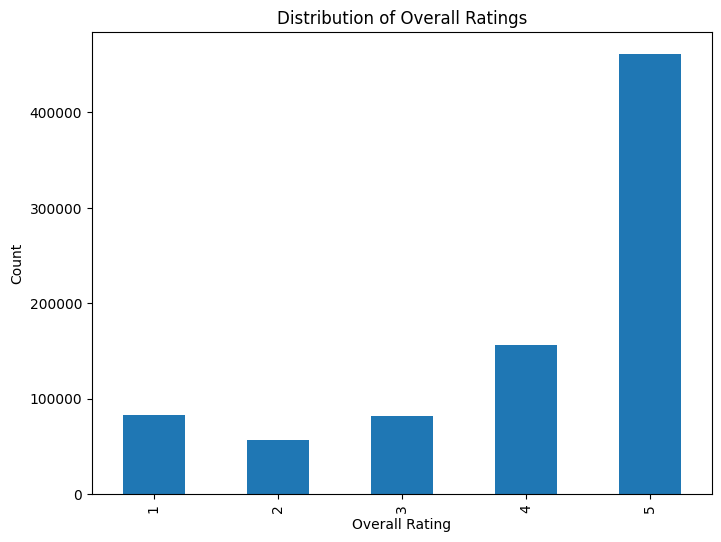

In [13]:
plt.figure(figsize=(8, 6))
train['overall'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.show()

Adding some mathematical backbone to our implentation:

In [14]:
rating_distribution = train['overall'].value_counts().sort_index()
is_balanced = rating_distribution.min() / rating_distribution.max() >= 0.7
print("Is the dataset balanced?", is_balanced)

Is the dataset balanced? False


As it is shown, we need to handle the imbalancement.

We need to make sure that no overfitting is being made, so if we have got overfitting in our final results this is a checkpoint for sure!

We will use the IMBlearn random oversampler and undersampler for the purpose and in order to make a cautious step overfitting wise, we will bring all the samples to 250000 occurances:

In [15]:
train["overall"].value_counts()

overall
5    461485
4    156514
1     82950
3     81239
2     56756
Name: count, dtype: int64

In [16]:
undersampler = RandomUnderSampler(sampling_strategy={1: 82950, 2: 56756, 3: 81239, 4: 149999, 5: 149999}, random_state=78)
oversampler = RandomOverSampler(sampling_strategy={1: 150000, 2: 150000, 3: 150000, 4: 150000, 5: 150000}, random_state=78)

X_resampledo, y_resampledo = undersampler.fit_resample(train.drop(columns=["overall"]), train['overall'])
X_resampled, y_resampled = oversampler.fit_resample(X_resampledo, y_resampledo)

In [17]:
balanced_distribution = y_resampled.value_counts().sort_index()
print("Balanced Rating Distribution:")
print(balanced_distribution)

Balanced Rating Distribution:
overall
1    150000
2    150000
3    150000
4    150000
5    150000
Name: count, dtype: int64


We will use this method when encountering the main model training results and not in the analytical parts.

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Question 2:
</font>
</h3>


After the imbalancement handling, we will go for positive, neutral, and negative wordclouds:

In [18]:
nltk.download('stopwords')
positive_reviews = train[train['overall'].isin([4, 5])]
neutral_reviews = train[train['overall'] == 3]
negative_reviews = train[train['overall'].isin([1, 2])]
positive_text = " ".join(positive_reviews['reviewText'])
neutral_text = " ".join(neutral_reviews['reviewText'])
negative_text = " ".join(negative_reviews['reviewText'])
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
wordcloud_positive = WordCloud(stopwords=stop_words, background_color='white').generate(positive_text)
wordcloud_neutral = WordCloud(stopwords=stop_words, background_color='white').generate(neutral_text)
wordcloud_negative = WordCloud(stopwords=stop_words, background_color='white').generate(negative_text)

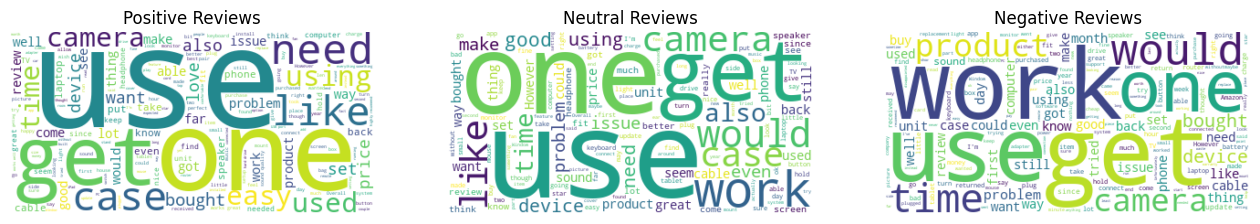

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis("off")

plt.subplot(132)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis("off")

plt.subplot(133)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis("off")

plt.show()

As it is shown, we still have some words that are not meant to be there and they are in every class so we will try to delete them too in order to get a better result:

In [21]:
stop_words.add('one')
stop_words.add('get')
stop_words.add('camera')
stop_words.add('need')
stop_words.add('product')
stop_words.add('work')
stop_words.add('time')
stop_words.add('use')
stop_words.add('device')
stop_words.add('would')
stop_words.add('also')
stop_words.add('bought')
stop_words.add('case')
stop_words.add('like')

In [22]:
wordcloud_positive = WordCloud(stopwords=stop_words, background_color='white').generate(positive_text)
wordcloud_neutral = WordCloud(stopwords=stop_words, background_color='white').generate(neutral_text)
wordcloud_negative = WordCloud(stopwords=stop_words, background_color='white').generate(negative_text)

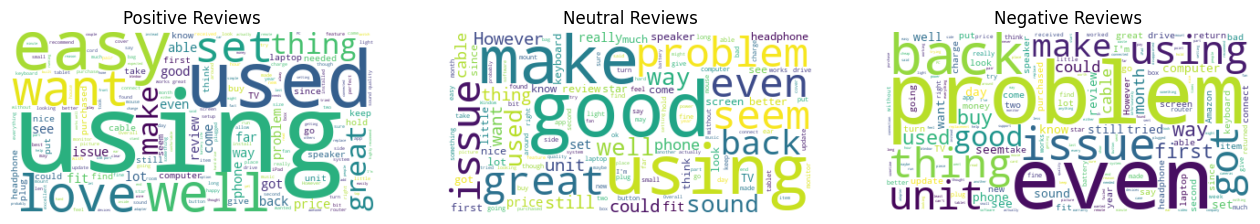

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis("off")

plt.subplot(132)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis("off")

plt.subplot(133)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis("off")

plt.show()

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Question 3:
</font>
</h3>


Now we will find the top 10 useful users:

In [24]:
top_reviewers = train.groupby('reviewerID')['vote'].sum().reset_index()
top_reviewers = top_reviewers.sort_values(by='vote', ascending=False)
top_10_reviewers = top_reviewers.head(10)
top_10_reviewer_info = top_10_reviewers.merge(train[['reviewerID', 'reviewerName']], on='reviewerID')
top_10_reviewer_info = top_10_reviewer_info.drop_duplicates(subset='reviewerName')
t10df = pd.DataFrame(top_10_reviewer_info[['reviewerName', 'vote']])
print("Top 10 Reviewers with Most Votes:")
t10df

Top 10 Reviewers with Most Votes:


,reviewerName,vote
0,Benson Leung,4572.0
29,Obi Wan,1608.0
58,Chris Winter,1352.0
62,Mayra S.,1342.0
81,VermontGuy,1337.0
88,Michael,1230.0
220,PhotoGraphics,1209.0
288,Nicholas,1188.0
311,NLee the Engineer,1103.0
342,David H,1045.0


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Question 4:
</font>
</h3>


Original one :

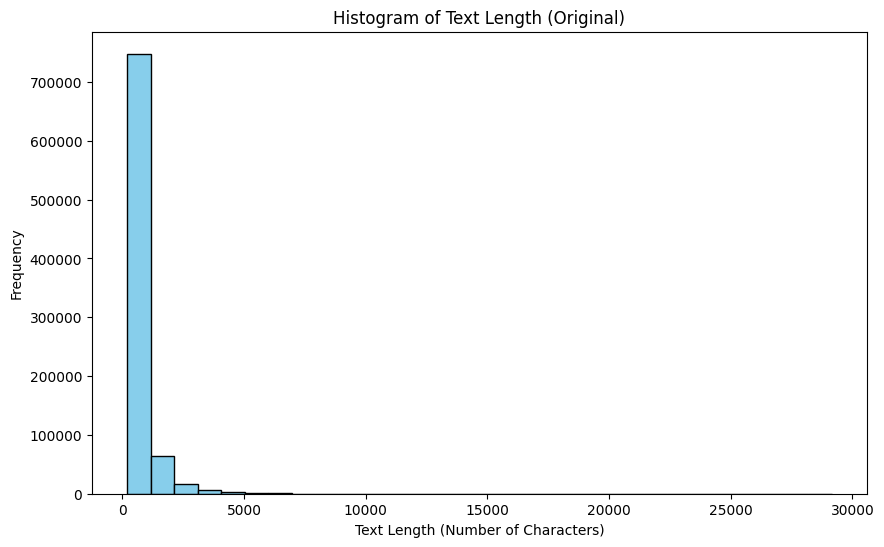

In [25]:
train['text_length'] = train['reviewText'].str.len()

plt.figure(figsize=(10, 6))
plt.hist(train['text_length'], bins=30, color='skyblue', edgecolor="black")
plt.title('Histogram of Text Length (Original)')
plt.xlabel('Text Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

Let's find the filter boundaries with the IQR method:

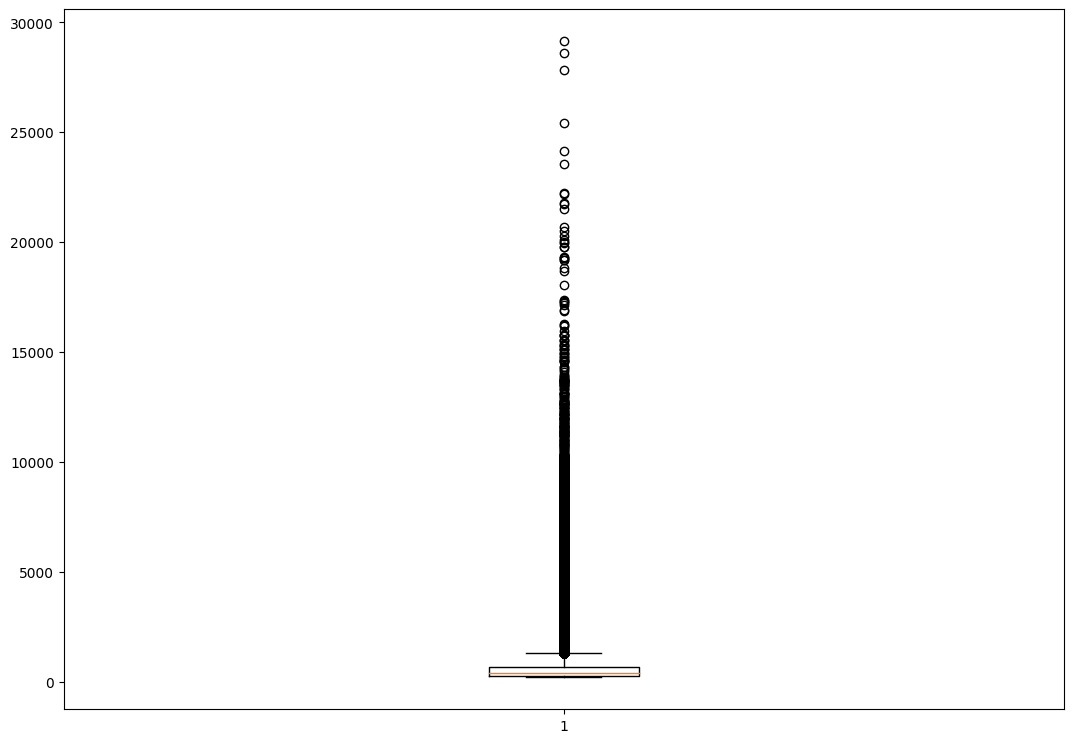

In [26]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot((train["text_length"]))
plt.show()

In [27]:
m = np.mean(train["text_length"])
q3, q1 = np.percentile(train["text_length"], [75 ,25])
iqr = q3 - q1
lower = m - 1.5*iqr
upper = m + 1.5*iqr
(lower, upper)

(-5.312615621543273, 1254.6873843784567)

We don't have a -5 characters long word, so we will consider the lower bound as 0.

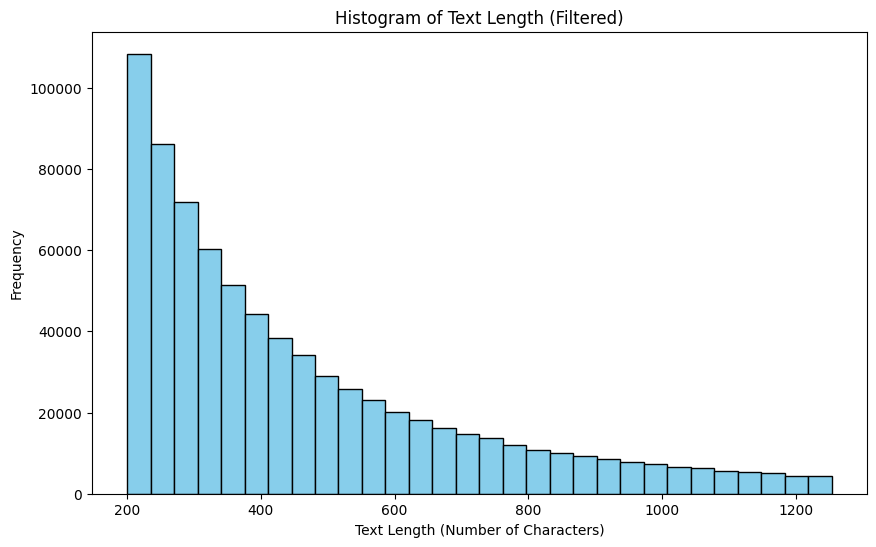

In [28]:
filtered_data = train[(train['text_length'] >= 0) & (train['text_length'] <= upper)]

plt.figure(figsize=(10, 6))
plt.hist(filtered_data['text_length'], bins=30, color='skyblue', edgecolor="black")
plt.title('Histogram of Text Length (Filtered)')
plt.xlabel('Text Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

Based on the analysis of the histogram of text lengths, it seems that setting a constraint on the text length during modeling could be beneficial. 

The filtered histogram with a minimum of 0 characters and a maximum of approximately 12500 characters resulted in a smoother distribution of text lengths.

Therefore, it is advisable to impose constraints on the text length during modeling.

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Question 5:
</font>
</h3>

10 most five stars

In [29]:
five_star_reviews = train[train['overall'] == 5]

top_products = five_star_reviews.groupby('asin')['overall'].count().reset_index()
top_products = top_products.rename(columns={'overall': 'num_5_star_reviews'})
top_products = top_products.sort_values(by='num_5_star_reviews', ascending=False)
top_products = top_products.merge(titles[['asin', 'title', 'brand']], on='asin', how='left')

In [30]:
top_10_products = top_products.head(10)
t10pdf = pd.DataFrame(top_10_products[['brand', 'title', 'num_5_star_reviews']])
print("10 most five stars rated products:")
t10pdf

10 most five stars rated products:


,brand,title,num_5_star_reviews
0,Cambridge Soundworks,OontZ Angle 3 Enhanced Stereo Edition IPX5 Spl...,1163
1,NETGEAR,NETGEAR N300 WiFi Range Extender (EX2700),659
2,Roku,Roku Streaming Stick (3600R) - HD Streaming Pl...,600
3,StarTech,StarTech USB 2.0 to SATA IDE Adapter (USB2SATA...,598
4,Logitech,Logitech M570 Wireless Trackball Mouse &ndash;...,552
5,Samsung,Samsung 850 EVO 500GB 2.5-Inch SATA III Intern...,529
6,Asus,ASUS Tri-Band Gigabit (AC3200) WiFi Router (Up...,471
7,VideoSecu,VideoSecu ML531BE TV Wall Mount for Most 27&qu...,448
8,"Arlo Technologies, Inc",Arlo - Wireless Home Security Camera System | ...,433
9,Samsung,Samsung 850 EVO 250GB 2.5-Inch SATA III Intern...,431


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Question 6:
</font>
</h3>

10 most reviewed brands and their score mean 

In [31]:
merged_data = pd.merge(train, titles, on='asin')

brand_stats = merged_data.groupby('brand').agg({'overall': ['count', 'mean']})
brand_stats.columns = ['num_reviews', 'average_rating']
top_10_brands = brand_stats.sort_values(by='num_reviews', ascending=False).head(10)

In [32]:
top_10_brands

,num_reviews,average_rating
brand,,
Logitech,17066,3.954061
Samsung,15409,3.941268
AmazonBasics,13213,4.201468
Sony,12436,3.938726
Asus,11928,3.855550
Anker,9860,4.244320
TP-LINK,9773,3.928681
SanDisk,8400,3.958810
Sabrent,7320,4.028005


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Data Explanation:
</font>
</h3>

In [33]:
train

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,text_length
0,2,0.0,0,2016-11-11,A2OSUEZJIN7BI,0511189877,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn,561
1,5,0.0,1,2016-06-06,A2NETQRG6JHIG7,0511189877,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?,450
2,4,0.0,1,2016-03-10,A12JHGROAX49G7,0511189877,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.,205
3,5,0.0,1,2016-01-14,A1KV65E2TMMG6F,0511189877,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,284
4,5,0.0,1,2016-10-20,A280POPEWI0NSA,0594459451,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord,247
...,...,...,...,...,...,...,...,...,...,...
838939,5,0.0,1,2017-07-25,A1OOVLE2KZ6KGA,B01HJCN1EI,Puddzee,These are my favorite charging cords for a few...,Worth the price.,276
838940,1,0.0,1,2017-04-04,A77K1B31UAQ29,B01HJCN1EI,addictedtoreading,"Update....after 2 months of gentle use, cable ...",UPDATE...BREAKS AND SLOW CHARGING,228
838941,3,0.0,1,2017-07-08,A2SVXUVUAWUDK2,B01HJH42KU,Andrew,These are okay. The connection becomes very if...,Hope this makes sense. You'd understand if you...,242
838942,5,2.0,1,2016-12-01,A2HUZO7MQAY5I2,B01HJH40WU,michael clontz,"Ok here is an odd thing that happened to me, I...",Not the correct product as linked in the sale.,528


In [34]:
test

,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary
0,0.0,1,2018-06-04,A20GGWE66JW9X2,B006Z394GM,Brian C Toner,The name and description of this device are mi...,The prize for most useless invention of all ti...
1,0.0,1,2018-02-18,ARYJWXHEYHG9M,B005BE058W,Snake,One of the molex connectors on the power suppl...,MELTED MOLEX CONNECTOR
2,0.0,1,2018-01-20,A10LHZ7WFZ7HLL,B01DA0YCNC,Amazon Customer,Remote constantly disconnects/ Roku player fre...,Bricked on the regular
3,0.0,1,2018-06-25,A11VN8EOHNLP72,B00FBJ4KYC,Jeremy Bray,I purchased this 4 year protection plan for a ...,DO NOT BUY!!!
4,3.0,1,2016-08-17,A194Y8P8TVT7P9,B00P7G82TS,Mark,I bought one of these and have regretted it ev...,Nightmare - don't buy
...,...,...,...,...,...,...,...,...
19995,0.0,1,2016-08-18,A2938GNQGHT0BL,B01DACQMH4,Sarah White,"I've just had it up and running for 3 days, bu...",but so far I'm pretty pleased. I upgraded from...
19996,0.0,1,2018-04-09,ALL1OIDIGVJDH,B005HGM1D6,Amigaman,Looking for high quality audio interconnect ca...,High Quality Audio Interconnects
19997,0.0,1,2016-01-20,A17HGOTUOG2BFJ,B007FMG6D6,Luke Snedecor,Perfect! Does exactly as told. The cable is a ...,Totally works!
19998,3.0,1,2016-01-13,A1HC6MT5PMOIRN,B00KQCOV5C,Richmond Mensah,I bought this for my dell latitude e6330. I wa...,Dell latitude E6330


In [38]:
check = test[test["asin"].isin(train["asin"])].dropna()
check

,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary
0,0.0,1,2018-06-04,A20GGWE66JW9X2,B006Z394GM,Brian C Toner,The name and description of this device are mi...,The prize for most useless invention of all ti...
1,0.0,1,2018-02-18,ARYJWXHEYHG9M,B005BE058W,Snake,One of the molex connectors on the power suppl...,MELTED MOLEX CONNECTOR
2,0.0,1,2018-01-20,A10LHZ7WFZ7HLL,B01DA0YCNC,Amazon Customer,Remote constantly disconnects/ Roku player fre...,Bricked on the regular
4,3.0,1,2016-08-17,A194Y8P8TVT7P9,B00P7G82TS,Mark,I bought one of these and have regretted it ev...,Nightmare - don't buy
5,0.0,1,2017-09-15,ACZDN5A7ZH6RM,B006FKAZ36,Dj Breaz,Item came in with good timing. I went to use t...,Good Feel But Did Not Work.
...,...,...,...,...,...,...,...,...
19995,0.0,1,2016-08-18,A2938GNQGHT0BL,B01DACQMH4,Sarah White,"I've just had it up and running for 3 days, bu...",but so far I'm pretty pleased. I upgraded from...
19996,0.0,1,2018-04-09,ALL1OIDIGVJDH,B005HGM1D6,Amigaman,Looking for high quality audio interconnect ca...,High Quality Audio Interconnects
19997,0.0,1,2016-01-20,A17HGOTUOG2BFJ,B007FMG6D6,Luke Snedecor,Perfect! Does exactly as told. The cable is a ...,Totally works!
19998,3.0,1,2016-01-13,A1HC6MT5PMOIRN,B00KQCOV5C,Richmond Mensah,I bought this for my dell latitude e6330. I wa...,Dell latitude E6330


We know that some of test asins are not available in the train data asin so we must make sure that we will get rid of that column when we are in part 3.

For part 2, we will limit our overall mean to our train dataset.

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Part 2:
</font>
</h3>

Finding warrantee related overall score for each product:

In [40]:
df = train[["asin", "reviewText", "overall"]]
df

,asin,reviewText,overall
0,0511189877,I have an older URC-WR7 remote and thought thi...,2
1,0511189877,First time I've EVER had a remote that needed ...,5
2,0511189877,Got them and only 2 of them worked. company ca...,4
3,0511189877,I got tired of the remote being on the wrong s...,5
4,0594459451,After purchasing cheap cords from another webs...,5
...,...,...,...
838939,B01HJCN1EI,These are my favorite charging cords for a few...,5
838940,B01HJCN1EI,"Update....after 2 months of gentle use, cable ...",1
838941,B01HJH42KU,These are okay. The connection becomes very if...,3
838942,B01HJH40WU,"Ok here is an odd thing that happened to me, I...",5


We'll use chatGPT for common mistakes and common synonyms for warranties and guarantees:

In [42]:
keywords = ["guarantee", "guaranteed", "guarantees", "warranty", "warranties", "warranted",
"assurance", "assured", "promised", "coverage", "insured", "warrantee",
"security", "pledge", "commitment", "contract", "protection", "safeguard",
"agreement", "bond", "certainty", "certified", "guarantor", "vouch", "pledged",
"ensured", "policy", "reassurance", "warranting", "certify", "promise",
"word", "wording", "guaranty", "pledge", "certification",
# Common typing issues and misspellings
"garantee", "waranty", "gaurantee", "warrantee", "garranty", "warantee",
"guarntee", "garanty", "gurantee", "waranties", "garantee", "guranty",
"guarnatee", "guarntee", "guaranties", "warrenty", "waranties", "warant",
"garentee", "guranty", "garanties", "warenty", "warrantees", "warraty"]

In [43]:
def mentions_guarantee_or_warranty(text):
    for keyword in keywords:
        if re.search(rf'\b{re.escape(keyword)}\b', text, re.I):
            return True
    return False

In [44]:
filtered_df = df[df['reviewText'].apply(mentions_guarantee_or_warranty)]
filtered_df

,asin,reviewText,overall
32,0972683275,One of the bolts seems to come loose with side...,3
53,140053271X,"If you want a top-line ereader, go with one of...",4
78,1495443043,For the most part this was a very sweet story....,3
122,980035977X,"Did not work with my printer, took a call to T...",1
167,B000001OM4,This adapter works well with my 1994 Corvette....,4
...,...,...,...
838879,B01HI9GG30,This is a very attractive and solidly made cab...,1
838891,B01HIA63ZA,The XTi series is Corsair's flagship SSD. The ...,5
838901,B01HIQYWU2,Here's the issue with this case. It protects ...,3
838904,B01HIS3FGW,"Great work/laptop bag, simplified travel! I lo...",4


In [49]:
merged_data = pd.merge(filtered_df, titles, on='asin')
merged_data

,asin,reviewText,overall,title,brand
0,0972683275,One of the bolts seems to come loose with side...,3,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...",VideoSecu
1,140053271X,"If you want a top-line ereader, go with one of...",4,Barnes &amp; Noble Nook Simple Touch eBook Rea...,Barnes &amp; Noble
2,1495443043,For the most part this was a very sweet story....,3,Country Heaven (Dare River),Visit Amazon's Ava Miles Page
3,980035977X,"Did not work with my printer, took a call to T...",1,TP-LINK TL-PS110U Single USB2.0 port fast ethe...,TP-LINK
4,980035977X,I use this device as a work around to an issue...,5,TP-LINK TL-PS110U Single USB2.0 port fast ethe...,TP-LINK
...,...,...,...,...,...
59837,B01HH5G93C,iPad Pro 9.7 Case by KIQ (TM) Heavy Duty Hybri...,5,iPad Pro 9.7 2016 case by KIQ Heavy Duty Hybri...,KIQ
59838,B01HHR572O,This is a photographer's camera. If you shoot ...,5,Sigma SD Quattro Digital Camera with 30mm F1.4...,Sigma
59839,B01HHRGSEA,This is my fourth of these tablets. The first...,1,9.7 inch Tablet Octa Core 2560X1600 IPS Blueto...,FX
59840,B01HI9GG30,This is a very attractive and solidly made cab...,1,3.5mm Stereo Audio AUX Cable w/ Straight Male ...,Beautiful-tech


Now that we have filtered data and have the asin title, we can calculate the respective mean for each product:

In [70]:
grouped = pd.DataFrame(merged_data.groupby('title').agg(Mean=('overall', np.mean),Sum=('overall', np.sum))).reset_index()
grouped['Count'] = grouped["Sum"]/ grouped["Mean"]
grouped.drop(columns=["Sum"], inplace=True)
grouped

,title,Mean,Count
0,PTC Premium Gold Series HDMI hembra/hembra C...,2.0,1.0
1,2 Pack Charge &amp; Sync Cable Adapter Conver...,4.5,2.0
2,4 Port Cable TV/HDTV/Digital Amplifier Intern...,5.0,3.0
3,ACDelco 19116641 GM Original Equipment Front ...,2.5,4.0
4,AKG K702 Reference Class Studio Headphones,4.0,1.0
...,...,...,...
23393,xmartO [Audio Video &amp; Color Night Vision] ...,3.0,2.0
23394,yellow iPad Mini Case,4.0,2.0
23395,yueton Pack of 5 Nickel Plated HDMI Female to ...,5.0,1.0
23396,zdMoon Coffee Leather Camera case cover pouch ...,4.0,1.0


We assume that any score that is consisted of less than 10 votes is not that reliable so we will delete them.

In [71]:
grouped = grouped[grouped["Count"]>=10]
grouped

,title,Mean,Count
10,Belkin BZ103050-TVL Mini Surge Protector with...,4.018182,55.0
17,Case Logic SLRC-201 SLR Zoom Holster (Black),4.500000,10.0
50,Logitech Performance MX Wireless Mouse (DISCO...,3.666667,21.0
89,TII 212 Broadband Cable TV and Satellite Ligh...,4.900000,10.0
90,TP-Link 16-Port Gigabit Ethernet Unmanaged Sw...,4.058824,34.0
...,...,...,...
23280,mCover iPearl Hard Shell Case with FREE keyboa...,4.833333,12.0
23347,tomtoc 13 inch Laptop Sleeve Bag Compatible wi...,4.333333,12.0
23348,tomtoc 360&deg; Protective Laptop Carrying Cas...,4.473684,19.0
23349,tomtoc 360&deg; Protective Laptop Sleeve Compa...,4.589286,56.0


In [72]:
grouped = grouped.sort_values(["Mean", "Count"], ascending=False).reset_index(drop=True)
grouped

,title,Mean,Count
0,SE FC9955 Dummy Sensor Security Camera,5.000000,43.0
1,Blitzby Apple Watch Screen Protector 44mm (7 P...,5.000000,14.0
2,Alcoco Headphpone Splitter Adapter Jack Adapto...,5.000000,13.0
3,OMOTON Kindle Paperwhite Case Cover - The Thin...,5.000000,13.0
4,"Noctua NF-F12 PWM, 4-Pin Premium Quiet Fan (12...",5.000000,12.0
...,...,...,...
850,Microsoft Band 2 - Medium,1.796296,54.0
851,D-Link Camera Video Recorder mydlink-Enabled (...,1.750000,12.0
852,SuperSonic 1080p LED Widescreen HDTV with HDMI...,1.700000,10.0
853,Seagate Backup Plus Slim 2TB Portable Hard Dri...,1.647059,17.0


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Top 15 Guarantee Wise:
</font>
</h3>

In [73]:
grouped.head(15)

,title,Mean,Count
0,SE FC9955 Dummy Sensor Security Camera,5.000000,43.0
1,Blitzby Apple Watch Screen Protector 44mm (7 P...,5.000000,14.0
2,Alcoco Headphpone Splitter Adapter Jack Adapto...,5.000000,13.0
3,OMOTON Kindle Paperwhite Case Cover - The Thin...,5.000000,13.0
4,"Noctua NF-F12 PWM, 4-Pin Premium Quiet Fan (12...",5.000000,12.0
5,Mediabridge Ethernet Cable (25 Feet) - Support...,4.916667,12.0
6,[2 in 1 Pack] Anker USB-C (Male) to Micro USB ...,4.909091,11.0
7,Uoobag Tigernu Series Business Laptop Backpack...,4.900000,20.0
8,TII 212 Broadband Cable TV and Satellite Ligh...,4.900000,10.0
9,B+W 72mm XS-Pro Clear with Multi-Resistant Coa...,4.900000,10.0


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Worst 15 Guarantee Wise:
</font>
</h3>

In [74]:
grouped.tail(15)

,title,Mean,Count
840,PNY Turbo 32GB USB 3.0 Flash Drive - P-FD32GTB...,2.000000,12.0
841,Spy Tec Mini USB Dash Cam 10 Foot Hardwire Kit...,2.000000,11.0
842,Uniden UDR444 Guardian 4.3-Inch Video Surveill...,2.000000,10.0
843,CANARY (CAN100USBK) All-in-One Indoor 1080p HD...,1.961538,52.0
844,FLIR FX Indoor Wi-Fi Wireless 1080P HD Video M...,1.928571,14.0
845,(Old Model) Seagate 500GB Desktop HDD SATA 6Gb...,1.925926,27.0
846,Samsung EVO 64GB 48/MB/s Micro SDXC Memory Ca...,1.909091,55.0
847,SmartGuard 13-Month Tablet Accident Protection...,1.900000,10.0
848,Zmodo SPoE Security System - 4 Channel NVR &am...,1.900000,10.0
849,Lexar High-Performance microSDHC 633x 16GB UHS...,1.888889,18.0


We can do the same thing for different KPIs.

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Part 3 pre:
</font>
</h3>

Preprocessing our data to make sure it is aligned with what we pursue:

First of all we need to define a good and meaningful dataset for our model and therefore we have to filter our dataset.

For example "text_lenght", "reviewerName" and "reviewerID" columns won't add any data about the comments.

"vote" and "verified" columns show how much an idea is popular within others and this won't affect this specific question.

Also we can assume that the "reviewTime" column won't be much of a help too because it might not have that much effect on our model's accuracy. (We know that a product's quality may differ time to time but in a sentiment analysis question that's not what we are pursuig.)

After all, we will have a dataset consisted of:

"asin" to show what product is being commented,

"overall" to show its rating, 

"summary" as another sentiment factor,

And finally the "reviewText" column to show the main comments.

We also must remember that our data is imbalanced and we need to use the techniques we already discussed to handle that.

In [ ]:
newtrain = train.copy()
newtest = test.copy()

In [ ]:
newtrain.drop(columns=["asin", "vote", "verified", "text_length", "reviewerName", "reviewerID", "reviewTime"], inplace = True)
newtest.drop(columns=["asin", "vote", "verified", "reviewerName", "reviewerID", "reviewTime"], inplace = True)

In [ ]:
newtrain

,overall,asin,reviewText,summary
0,2,0511189877,I have an older URC-WR7 remote and thought thi...,Cannot Learn
1,5,0511189877,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?
2,4,0511189877,Got them and only 2 of them worked. company ca...,Works Good and programs easy.
3,5,0511189877,I got tired of the remote being on the wrong s...,Same as TWC remote
4,5,0594459451,After purchasing cheap cords from another webs...,Good Quality Cord
...,...,...,...,...
838939,5,B01HJCN1EI,These are my favorite charging cords for a few...,Worth the price.
838940,1,B01HJCN1EI,"Update....after 2 months of gentle use, cable ...",UPDATE...BREAKS AND SLOW CHARGING
838941,3,B01HJH42KU,These are okay. The connection becomes very if...,Hope this makes sense. You'd understand if you...
838942,5,B01HJH40WU,"Ok here is an odd thing that happened to me, I...",Not the correct product as linked in the sale.


We have already discussed over and under sampling methods and now we will use them,

There is a trade-off between how much we are going to sacrifice from the majority class and how much we are going to risk overfitting in the minority class!

Our call would be to sacrifice more rather than risking overfitting:

We have already discussed over and under sampling methods and now we will use them,

There is a trade-off between how much we are going to sacrifice from the majority class and how much we are going to risk overfitting in the minority class!

Our call would be to sacrifice more rather than risking overfitting:

In [ ]:
newtrain["overall"].value_counts()

In [ ]:
undersampler = RandomUnderSampler(sampling_strategy={1: 82950, 2: 56756, 3: 81239, 4: 149999, 5: 149999}, random_state=78)
oversampler = RandomOverSampler(sampling_strategy={1: 200000, 2: 200000, 3: 200000, 4: 200000, 5: 200000}, random_state=78)

X_resampledo, y_resampledo = undersampler.fit_resample(newtrain.drop(columns=["overall"]), newtrain['overall'])
X_resampled, y_resampled = oversampler.fit_resample(X_resampledo, y_resampledo)
X_resampled

In [ ]:
y_resampled.value_counts()

Now we have a dataset that we are sure is pretty effective as it don't have asin column and it has been balanced using a combo of under and over sampling.